In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "FRUIT-16K-PREPROCESSED/train/" # 80% of FRUIT-16K
test_dir = "FRUIT-16K-PREPROCESSED/test/" # 20% of FRUIT-16K

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 12800 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.


In [2]:
checkpoint_filepath = 'Xception_callbacks/'
Xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [3]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

In [4]:
base_model = tf.keras.applications.xception.Xception(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs)
print(f"Shape after base_model: {x.shape}")

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(16, activation="softmax", name="output_layer")(x)

Xception_model = tf.keras.Model(inputs, outputs)

Xception_model.compile(loss="categorical_crossentropy",
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

history_1 = Xception_model.fit(train_data,
                               epochs=20,
                               validation_data=valid_data,
                               validation_steps=len(valid_data),
                               callbacks=[Xception_checkpoint_callback, early_stopping])

Shape after base_model: (None, 7, 7, 2048)
After GlobalAveragePooling2D(): (None, 2048)
Epoch 1/20
400/400 [==============================] - 46s 102ms/step - loss: 0.3488 - accuracy: 0.9275 - val_loss: 0.1112 - val_accuracy: 0.9775
Epoch 2/20
400/400 [==============================] - 28s 71ms/step - loss: 0.0700 - accuracy: 0.9895 - val_loss: 0.0626 - val_accuracy: 0.9875
Epoch 3/20
400/400 [==============================] - 29s 71ms/step - loss: 0.0394 - accuracy: 0.9953 - val_loss: 0.0417 - val_accuracy: 0.9925
Epoch 4/20
400/400 [==============================] - 28s 71ms/step - loss: 0.0252 - accuracy: 0.9973 - val_loss: 0.0338 - val_accuracy: 0.9953
Epoch 5/20
400/400 [==============================] - 28s 70ms/step - loss: 0.0174 - accuracy: 0.9987 - val_loss: 0.0302 - val_accuracy: 0.9944
Epoch 6/20
400/400 [==============================] - 28s 70ms/step - loss: 0.0129 - accuracy: 0.9995 - val_loss: 0.0271 - val_accuracy: 0.9953
Epoch 7/20
400/400 [===========================

In [5]:
Xception_model.load_weights(checkpoint_filepath)

In [ ]:
Xception_model.save("Xception_model.h5")

In [7]:
import matplotlib.pyplot as plt

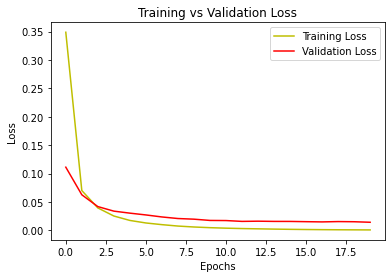

In [8]:
plt.plot(history_1.epoch, history_1.history["loss"], "y", label="Training Loss")
plt.plot(history_1.epoch, history_1.history["val_loss"], "r", label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

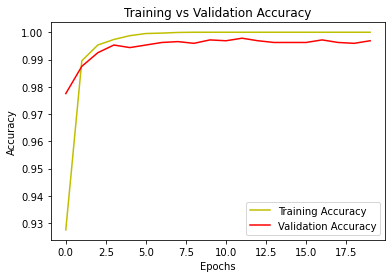

In [9]:
plt.plot(history_1.epoch, history_1.history["accuracy"], "y", label="Training Accuracy")
plt.plot(history_1.epoch, history_1.history["val_accuracy"], "r", label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()